# Anomaly Detection

In [ ]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

!pip install pyod
import pyod

In [2]:
data = pd.read_csv("drive/MyDrive/ML Project/Credit card fraud detection/creditcard.csv")

In [3]:
X = data.drop("Class", axis=1)
y = data['Class']

## Preprocessing

In [4]:
preprocess_feat = ['Time', 'Amount']
for feat in preprocess_feat:
    scaler = RobustScaler()
    data[feat] = scaler.fit_transform(X=data[feat].values.reshape(-1, 1))

## UMAP

* Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for     visualisation similarly to t-SNE. T-SNE takes a lot of time to complete so I have used UMAP.

* UMAP is fast and preserves the global structure i.e. the distance between data points within clusters and between clusters are preserved.

* Check out the below blogs for UMAP: 

    https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668
    
    https://towardsdatascience.com/tsne-vs-umap-global-structure-4d8045acba17

In [5]:
umap = pd.read_csv("drive/MyDrive/ML Project/Credit card fraud detection/UMAP_embed.csv")
dbscan_pred = pd.read_csv("/content/drive/MyDrive/ML Project/Credit card fraud detection/DBSCAN_Pred.csv")

In [6]:
umap["target"] = data['Class']
umap["dbscan_pred"] = dbscan_pred["pred"]

In [7]:
def compare_models(name, col):
    """
    Function for comparing the predicted labels and the actual labels for anomaly detection
    Args:
         Column in umap dataframe 
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))
    sns.scatterplot(x=umap['x_component'], y=umap["y_component"], hue=umap["target"], ax=ax[0]).set_title("Actual Labels")
    sns.scatterplot(x=umap['x_component'], y=umap["y_component"], hue=umap[col], ax=ax[1]).set_title(f"{name} predicted Labels")
    fig.show()

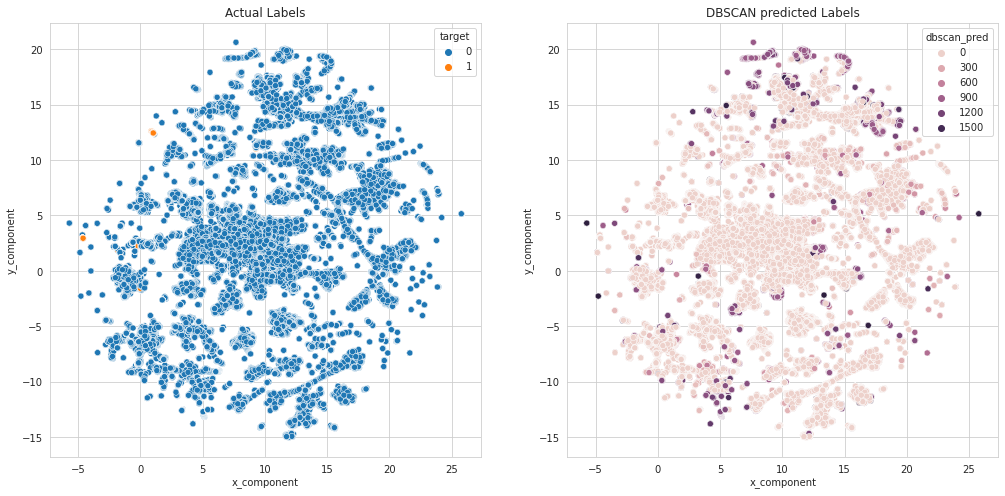

In [8]:
compare_models("DBSCAN", "dbscan_pred")

## Isolation Forest

In [9]:
IF_pred = IsolationForest().fit_predict(X)

In [10]:
umap["Isolation_forest"] = IF_pred

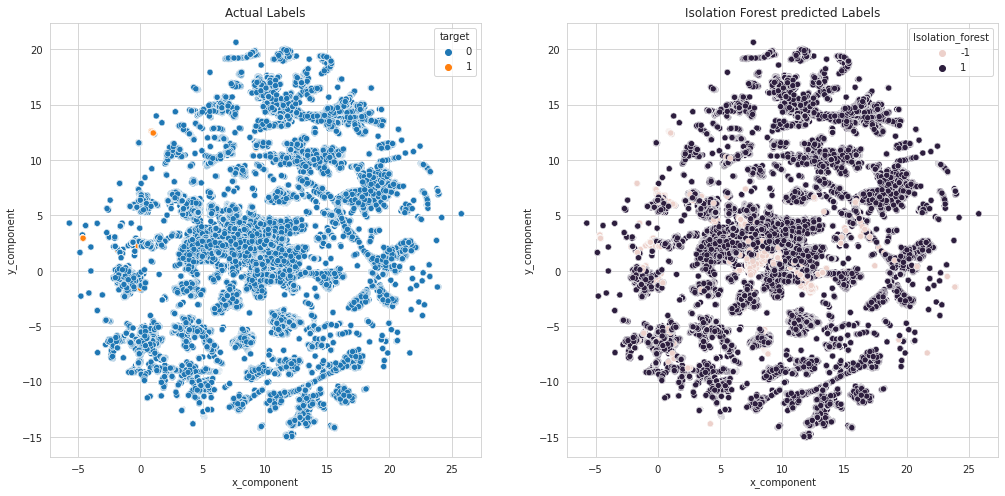

In [11]:
# Create the original scatter plot and the predicted scatter plot
# -1 in isolation forest indicates an outlier
compare_models("Isolation Forest", "Isolation_forest")

In [12]:
# Normal observations
print("Accuracy: ", list(IF_pred).count(1) / IF_pred.shape[0])

# Outlier observations
print("Outlier: ", list(IF_pred).count(-1) / IF_pred.shape[0])

Accuracy:  0.9625395443229977
Outlier:  0.03746045567700232


Observations:



## Local Outlier Factor

In [13]:
from sklearn.neighbors import LocalOutlierFactor

In [14]:
%%time
lof = LocalOutlierFactor().fit_predict(X)

CPU times: user 2min 5s, sys: 612 ms, total: 2min 6s
Wall time: 2min 5s


In [15]:
umap["LOF"] = lof

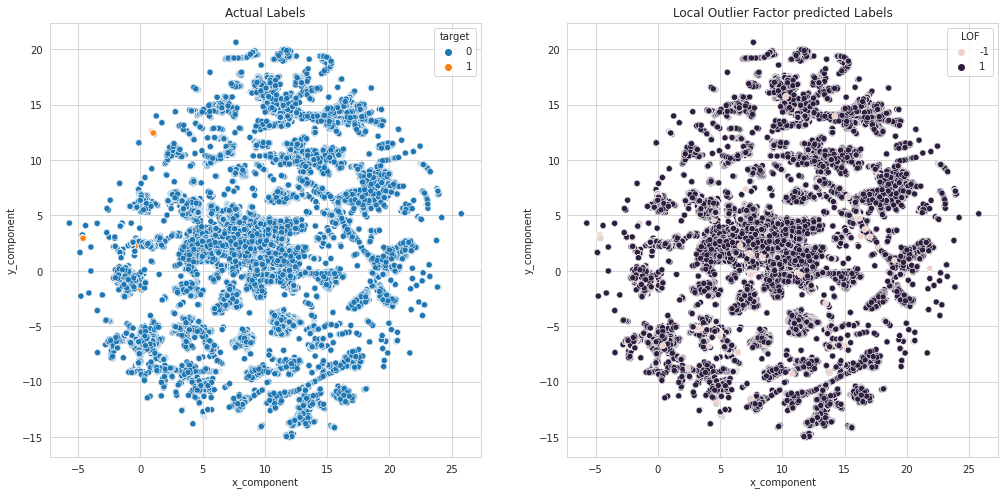

In [16]:
compare_models("Local Outlier Factor", "LOF")

In [17]:
# Normal observations
print("Accuracy: ", list(lof).count(1) / lof.shape[0])

# Outlier observations
print("Outlier: ", list(lof).count(-1) / lof.shape[0])

Accuracy:  0.984880989582419
Outlier:  0.01511901041758103


## Auto Encoders

In [18]:
from pyod.models.auto_encoder import AutoEncoder

In [19]:
ae = AutoEncoder(hidden_neurons=[30, 15, 15, 30], batch_size=64, epochs=15).fit_predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                4

In [20]:
umap['AE'] = ae

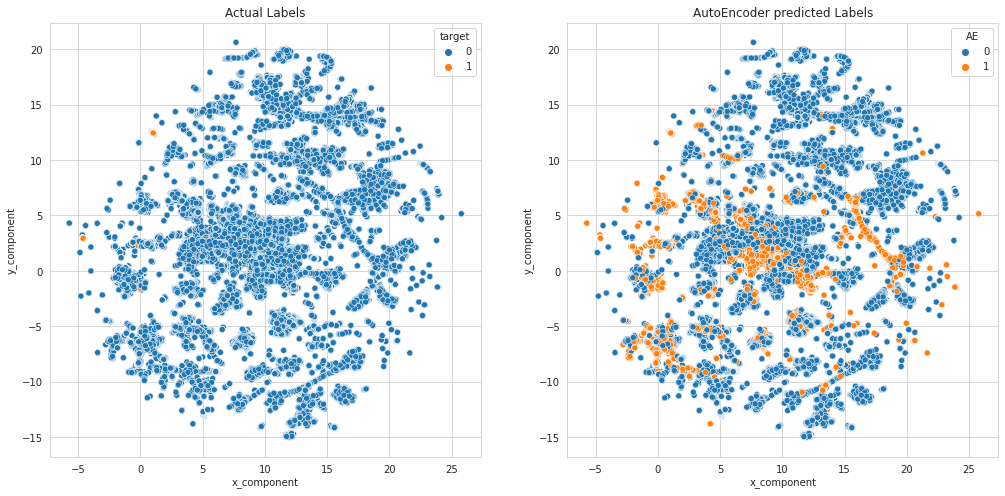

In [21]:
compare_models('AutoEncoder', "AE")

In [25]:
# Normal observations
print("Accuracy: ", list(ae).count(0) / ae.shape[0])

# Outlier observations
print("Outlier: ", list(ae).count(1) / ae.shape[0])

Accuracy:  0.8999989466551033
Outlier:  0.10000105334489671


In [27]:
umap.to_csv("outlier_prediction.csv", index=False)

## Conclusion:



*  From all the above anomaly detection algorithms Local Outlier Factor is the most accurate.

*  Isolation Forest has identified most of the fraud transaction but it has also identified non fraud transaction as fraud.

*  LOF has identified not fradulent transaction as fraud. One way to get accurate prediction is to remove this transaction from the dataset and train the model again to see if this works.
*  Auto Encoders predicted 10% outlier in the dataset which is not accurate.